**KBO기록실 데이터를 활용한 타자 성적예측**

# OPS 예측 방법

    - 1. 외부데이터 활용 [KBO 기록실](https://www.koreabaseball.com/Record/Player/HitterBasic/Basic1.aspx)
    
    >> 월(Month)별 예측해야 할 선수 10명의 기록을 가져옴
    
    - 2. 가져온 기록을 월별 OBP(출루율)와 SLG(장타율)로 구분하여 분석 진행함
    
    - 3. 이 때 일별 기록은 데이터가 상당히 불규칙하기 떄문에 예측에 어려움이 있어 월별로 집계하여 분석함
    
    - 4. 예측 모델로는 facebook Prophet을 사용하였다.

    - Facebook Prophet 모델의 주요 구성 요소는 Trend, Seasonality, Holiday 이다. 구체적인 내용으로는

$$ y(t) = g(t) + s(t) + h(t) + \epsilon_i $$

    - g(t)는 데이터의 전체 추세(trend)를 잡아줄 수 있고 
      s(t)는 반복적인 패턴(Seasonality)을 잡아줄 수 있고 
      h(t)는 불규칙적인 패턴(Holiday)을 잡아줄 수 있다. 

    - 따라서, Facebook Prophet은 전체 추세도 잘 잡는 동시에 규칙적, 비규칙적 패턴 모두를 잡을 수 있기 때문에 
    시계열 분석 및 예측에서 상당히 유연한 모델이라고 생각하였다. 

    - 게다가, 우리 데이터는 선수 마다 기록이 끝나는 월(Month)이 다른 경우도 있고, 중간 월(Month)에 기록이 없는 선수들도 있다. 
    그래서 일반 시계열 모델로는 이 빈 구간을 interpolation 해야 하는데 우리 데이터는 절대적인 양이 부족해 이 방법이 어렵다. 
    하지만 Facebook Prophet은 빈 구간에 대한 interpoliation을 하지 않아도 각 월(Month)의 패턴을 잘 잡아준다. 
    따라서 이와 같은 이유로 Facebook Prophet 모델을 차용하게 되었다.

# 1. 모듈 및 패키지 불러오기

In [1]:
# 기본모듈
import pandas as pd
import numpy as np
import datetime
import os 
import matplotlib.pyplot as plt
plt.style.use(['ggplot'])
import pickle
import sklearn
import seaborn as sns
import matplotlib

# 모델링모듈
import fbprophet
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterGrid
from tqdm import notebook
from fbprophet.plot import add_changepoints_to_plot

# 기타모듈
import warnings
warnings.filterwarnings(action='ignore')

# 버전 확인
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))
print('Scikit-Learn : %s'%(sklearn.__version__))
print('seaborn : %s'%(sns.__version__))
print('matplotlib : %s'%(matplotlib.__version__))
print('fbprophet : %s'%(fbprophet.__version__))
!python --version

Pandas : 1.3.2
Numpy : 1.19.5
Scikit-Learn : 0.23.2
seaborn : 0.11.2
matplotlib : 3.3.4
fbprophet : 0.7.1
Python 3.8.8


# 2. 데이터 불러오기 및 전처리

    - 외부 데이터 활용 [KBO 기록실](https://www.koreabaseball.com/Record/Player/HitterBasic/Basic1.aspx)
    
    - 10명의 선수별로 2018년부터 2021년 8월까지의 달별 기록을 활용하여 달별 OBP(출루율)와 SLG(장타율) 특성을 만듬 
    
    - 단, SF(희생플라이)는 기록에 존재하지 않기 때문에 대회에서 제공된 데이터에서 추가함

In [2]:
#데이터 불러오기
playerList = ['양의지', '강백호', '최정', '이정후', '채은성', '김재환', '전준우', '김현수', '박건우', '로맥']
playerCode = ['76232', '68050', '75847', '67341', '79192', '78224', '78513', '76290', '79215', '67872']
for player in playerList: 
    locals()[f'pieces{player}'] = [] # pieces 리스트안에 각 선수별 데이터를 추가하고 한 번에 concat함
    for year in range(2018,2022,1): # 각 년도 별로 선수별 데이터를 불러옴 
        train_path = '../data/sf_data' # 데이터 저장 경로 
        globals()[f'df{year}_{player}'] = pd.read_csv(train_path + f'\{player} {year}_sf.csv', encoding = 'utf8', index_col = 0) # 데이터 불러오기
        globals()[f'df{year}_{player}']['YEAR'] = f'{year}' #년도 구분추가
        locals()[f'pieces{player}'].append(globals()[f'df{year}_{player}']) #pieces리스트에 데이터 추가
    for code in playerCode: #concat하기 위함
        if playerList.index(player) ==playerCode.index(code):
            globals()[f'df_{code}'] = pd.concat(locals()[f'pieces{player}']) #pieces리스트 한번에 concat

submission = pd.read_excel('../input/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_평가데이터.xlsx'
                        ,index_col = 0) # 제출 파일 불러오기

### 2.1 OBP 및 SLG 열 추가

    - 기본 데이터에는 OBP 및 SLG에 대한 정보가 없으므로 OBP, SLG열을 추가해준다.
    - fbprophet으로 예측을 진행할 때, 0인 값은 좋은 예측을 하는데에 방해를 주기 때문에 이를 이상치로 판단하여 분석 데이터에서 제외함.

In [3]:

for player in playerCode:
    globals()[f'df_{player}']['OBP'] = (globals()[f'df_{player}']['H'] + globals()[f'df_{player}']['BB'] + globals()[f'df_{player}']['HBP']) / (globals()[f'df_{player}']['AB'] + globals()[f'df_{player}']['BB'] + globals()[f'df_{player}']['HBP'] + globals()[f'df_{player}']['SF'])
    globals()[f'df_{player}']['SLG'] = ((globals()[f'df_{player}']['H'] - globals()[f'df_{player}']['2B'] - globals()[f'df_{player}']['3B'] - globals()[f'df_{player}']['HR']) + (globals()[f'df_{player}']['2B'] * 2) + (globals()[f'df_{player}']['3B'] * 3) + (globals()[f'df_{player}']['HR'] * 4)) / globals()[f'df_{player}']['AB']
    idx = globals()[f'df_{player}'].query("OBP==0 or SLG==0").index
    globals()[f'df_{player}'] = globals()[f'df_{player}'].drop(idx)
    globals()[f'df_{player}'] = globals()[f'df_{player}'].reset_index()
    
    del globals()[f'df_{player}']['상대']
    del globals()[f'df_{player}']['level_0']

### 2.2 데이터 분석에 필요한 기능을 함수로 정의

In [4]:
# OBP, SLG 열 추가 및 날짜 칼럼 ds 생성 / train을 prophet에 넣을 수 있도록 ds와 y 열로 조정
def Preprocessing(data, target): 
    train = data
    train['OBP'] = (train['H'] + train['BB'] + train['HBP']) / (train['AB'] + train['BB'] + train['HBP'] + train['SF'])
    train['SLG'] = ((train['H'] - train['2B'] - train['3B'] - train['HR']) + (train['2B'] * 2) + (train['3B'] * 3) + (train['HR'] * 4)) / train['AB']
    train['ds'] = train['YEAR'].astype('str').str.cat(train['index'].str.split('월').str[0])
    train['ds'] =train['ds'].apply(lambda x : x[:4] + '-' + x[4:6])
    train['ds'] = train['ds'].apply(lambda x : datetime.datetime.strptime(x, '%Y-%m'))
    train = train[['ds', target]] # target : OBP or SLG
    train.columns = ['ds','y']
    return train

In [5]:
# forecast와 true값의 추세를 보여주는 그래프
def plot_result(forecast, train, spot):
    forecast = forecast[['ds', 'yhat']]
    forecast = forecast.reset_index()
    train_plot = train.reset_index(drop = True).reset_index()
    plt.figure(figsize = (15,5))
    plt.plot(forecast['ds'],forecast['yhat'], label = 'forecast')
    plt.plot(train_plot['ds'], train['y'], label = 'true')
    plt.scatter(forecast['ds'],forecast['yhat'])
    plt.scatter(train_plot['ds'], train['y'])
    plt.scatter(forecast[forecast['ds'] == "2021-08-01"]['ds'], spot, s = 100)
    plt.legend()
    plt.show()

## 3. 선수별 OBP, SLG 예측 

    
    - 검증은 21년 7월 전까지의 데이터를 학습데이터로, 21년 8월 실제값을 검증 데이터로 사용하여 예측값을 비교하여 
      가장 적합한 하이퍼파라미터로 튜닝함
      
    - 보라색 점이 실제 8월 Target 값이고 (OBP or SLG) 빨간 그래프가 예측값, 파란 그래프가 실제값이다. 
    
    - 특히, 하이퍼파라미터 튜닝 시 무조건 8월의 검증 실제값과 가까운 예측값을 모델로 뽑아내면 과적합이 되는 경우가 발생한다.
    
    - 이 경우는, Manual Search를 통해 적절한 하이퍼 파라미터로 튜닝한다.
    
    - 예측 기간이 9월 15일 ~ 10월 8일이기 때문에 9월 예측결과를 2/3, 10월 예측결과를 1/3 만큼 가중 평균하여 
      최종 예측값으로 사용한다.

### 3.1 양의지

* OBP

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


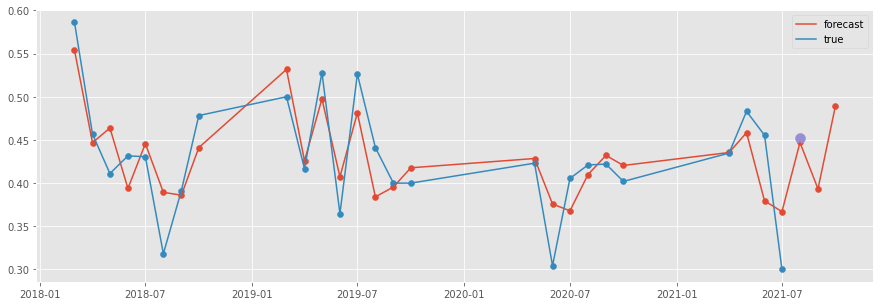

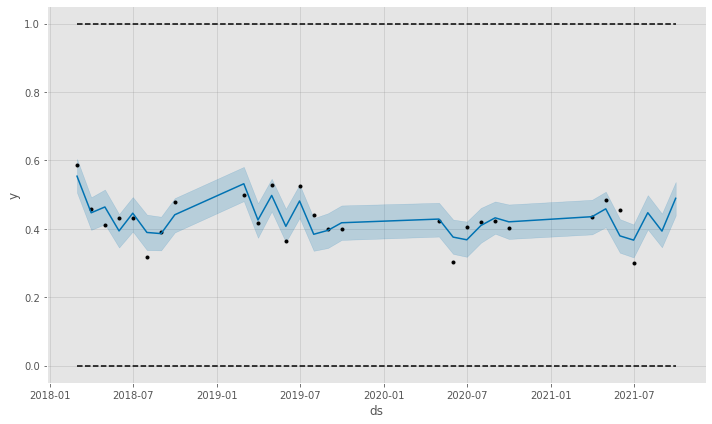

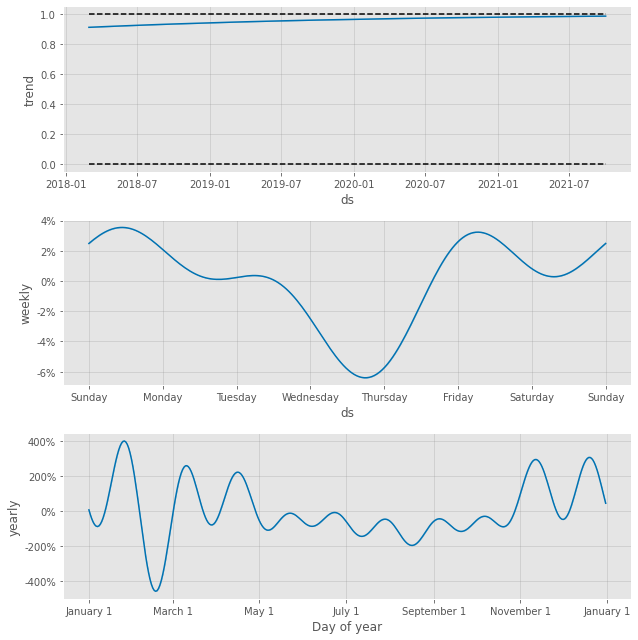

In [6]:
data = df_76232; target = 'OBP'
train = Preprocessing(data, target)
train = train.reset_index(drop = True)
np.random.seed(0)
train['cap'] = 1
train['floor'] = 0
model = Prophet(
                growth = 'logistic',
                seasonality_mode = 'multiplicative',
               changepoint_prior_scale = 1,
                seasonality_prior_scale = 1,
                yearly_seasonality = True,
                changepoint_range=0.8,
                weekly_seasonality= True,
                daily_seasonality = False
)
# 학습
model.fit(train)
# 예측 (3달 예측)
future = train[['ds']]
future.loc[26] = pd.to_datetime("2021-08-01")
future.loc[27] = pd.to_datetime("2021-09-01")
future.loc[28] = pd.to_datetime("2021-10-01")
future['cap'] = 1
future['floor'] = 0
forecast = model.predict(future)
plot_result(forecast, train, 0.4528301887)
fig1 = model.plot(forecast)
fig1 = model.plot_components(forecast)

In [7]:
OBP_76232 = (2/3 * forecast['yhat'].iloc[-2]) + (1/3 * forecast['yhat'].iloc[-1])
print(' 9월 예측 : {}'.format(forecast['yhat'].iloc[-2]))
print(' 10월 예측 : {}'.format(forecast['yhat'].iloc[-1]))
print(' 총 예측 : {}'.format(OBP_76232))

 9월 예측 : 0.3933253895000263
 10월 예측 : 0.48917081793899403
 총 예측 : 0.42527386564634884


* SLG

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


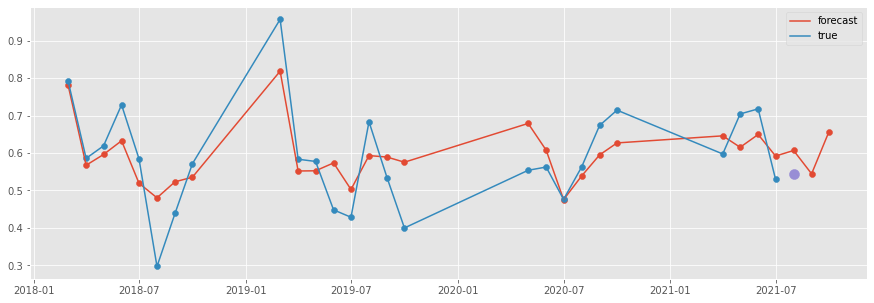

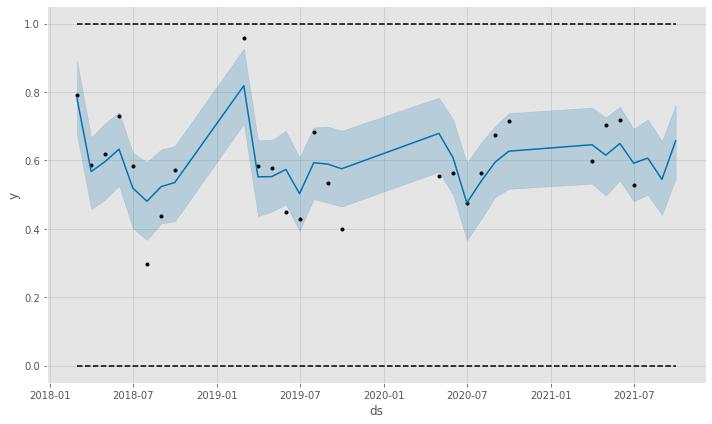

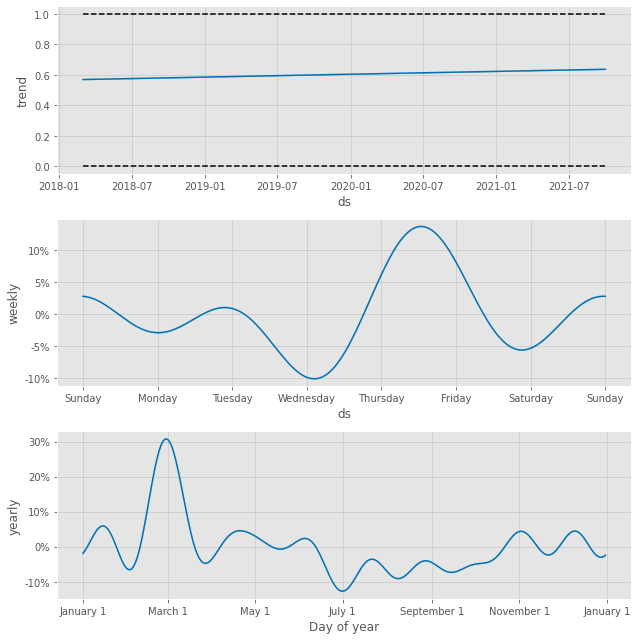

In [8]:
data = df_76232; target = 'SLG'
train = Preprocessing(data, target)
train = train.reset_index(drop = True)
np.random.seed(0)
train['cap'] = 1
train['floor'] = 0
model = Prophet(
                growth = 'logistic',
                seasonality_mode = 'multiplicative',
               changepoint_prior_scale = 0.05,
                seasonality_prior_scale = 0.05,
                yearly_seasonality = True,
                changepoint_range=0.8,
                weekly_seasonality= True,
                daily_seasonality = False
)
# 학습
model.fit(train)
# 예측 (3달 예측)
future = train[['ds']]
future.loc[26] = pd.to_datetime("2021-08-01")
future.loc[27] = pd.to_datetime("2021-09-01")
future.loc[28] = pd.to_datetime("2021-10-01")
future['cap'] = 1
future['floor'] = 0
forecast = model.predict(future)
plot_result(forecast, train, 0.543478260869565)
fig1 = model.plot(forecast)
fig1 = model.plot_components(forecast)

In [9]:
SLG_76232 = (2/3 * forecast['yhat'].iloc[-2]) + (1/3 * forecast['yhat'].iloc[-1])
print(' 9월 예측 : {}'.format(forecast['yhat'].iloc[-2]))
print(' 10월 예측 : {}'.format(forecast['yhat'].iloc[-1]))
print(' 총 예측 : {}'.format(SLG_76232))

 9월 예측 : 0.5444690440894934
 10월 예측 : 0.657253705720927
 총 예측 : 0.5820639312999712


### 3.2 강백호

* OBP

INFO:fbprophet:n_changepoints greater than number of observations. Using 18.


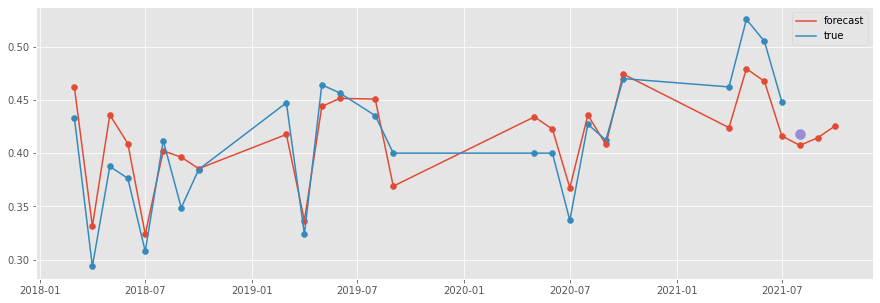

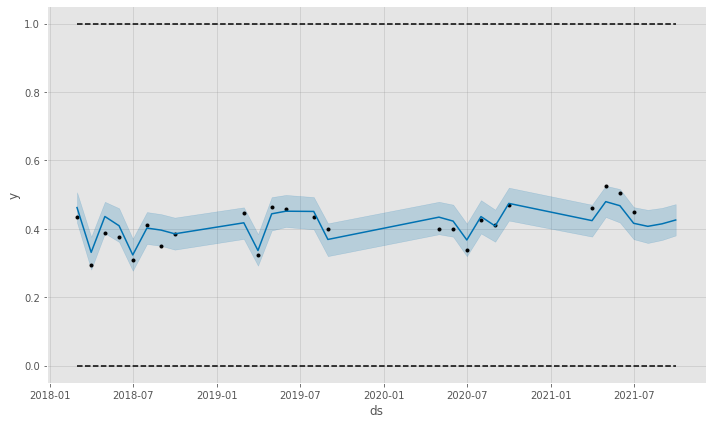

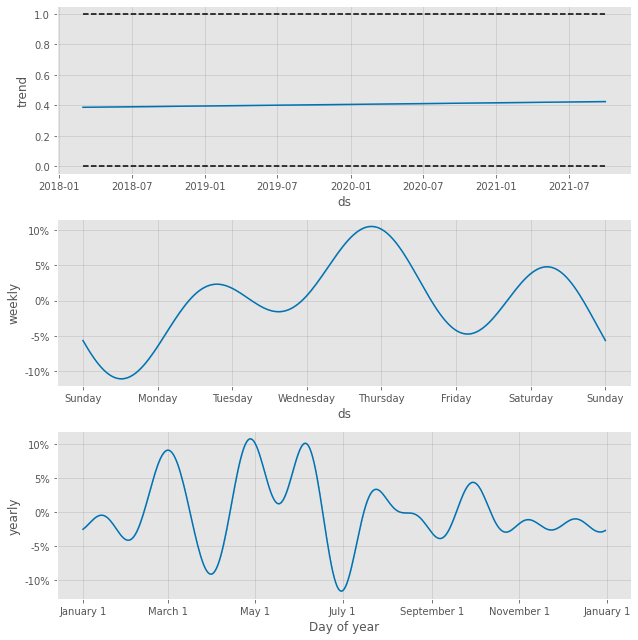

In [10]:
data = df_68050; target = 'OBP'
train = Preprocessing(data, target)
train = train.reset_index(drop = True)
np.random.seed(0)
train['cap'] = 1
train['floor'] = 0
model = Prophet(
                growth = 'logistic',
                seasonality_mode = 'multiplicative',
               changepoint_prior_scale = 0.0001,
                seasonality_prior_scale = 0.05,
                yearly_seasonality = True,
                changepoint_range=0.8,
                weekly_seasonality= True,
                daily_seasonality = False
)
# 학습
model.fit(train)
# 예측 (3달 예측)
future = train[['ds']]
future.loc[26] = pd.to_datetime("2021-08-01")
future.loc[27] = pd.to_datetime("2021-09-01")
future.loc[28] = pd.to_datetime("2021-10-01")
future['cap'] = 1
future['floor'] = 0
forecast = model.predict(future)
plot_result(forecast, train, 0.417721518987342)
fig1 = model.plot(forecast)
fig1 = model.plot_components(forecast)

In [11]:
OBP_68050 = (2/3 * forecast['yhat'].iloc[-2]) + (1/3 * forecast['yhat'].iloc[-1])
print(' 9월 예측 : {}'.format(forecast['yhat'].iloc[-2]))
print(' 10월 예측 : {}'.format(forecast['yhat'].iloc[-1]))
print(' 총 예측 : {}'.format(OBP_68050))

 9월 예측 : 0.41455154991876536
 10월 예측 : 0.4257654199069039
 총 예측 : 0.4182895065814782


* SLG

INFO:fbprophet:n_changepoints greater than number of observations. Using 18.


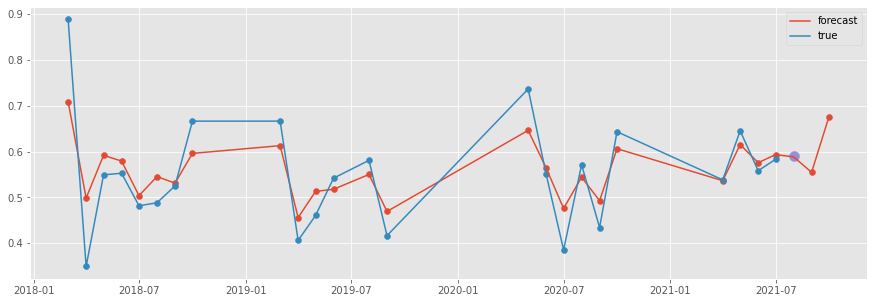

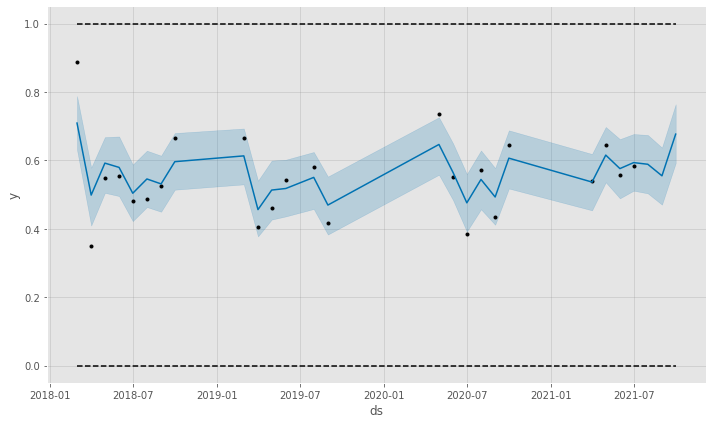

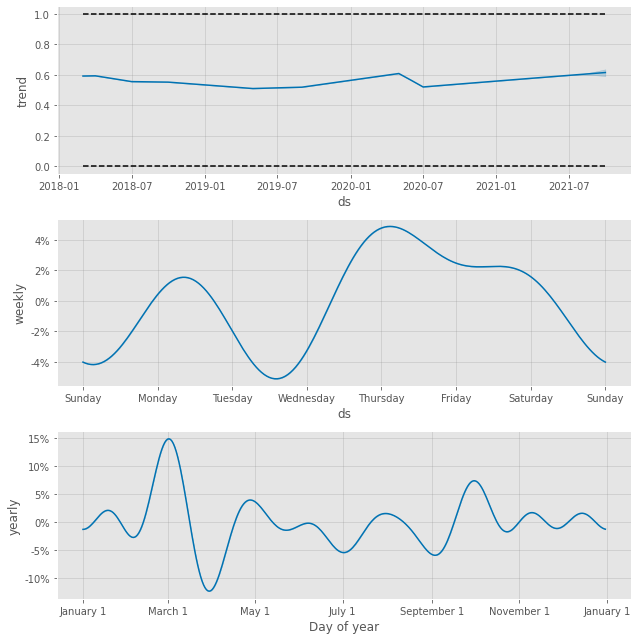

In [12]:
data = df_68050; target = 'SLG'
train = Preprocessing(data, target)
train = train.reset_index(drop = True)
np.random.seed(0)
train['cap'] = 1
train['floor'] = 0
model = Prophet(
                growth = 'logistic',
                seasonality_mode = 'multiplicative',
               changepoint_prior_scale = 10,
                seasonality_prior_scale = 0.02,
                yearly_seasonality = True,
                changepoint_range=0.8,
                weekly_seasonality= True,
                daily_seasonality = False
)
# 학습
model.fit(train)
# 예측 (3달 예측)
future = train[['ds']]
future.loc[26] = pd.to_datetime("2021-08-01")
future.loc[27] = pd.to_datetime("2021-09-01")
future.loc[28] = pd.to_datetime("2021-10-01")
future['cap'] = 1
future['floor'] = 0
forecast = model.predict(future)
plot_result(forecast, train, 0.590909090909091)
fig1 = model.plot(forecast)
fig1 = model.plot_components(forecast)

In [13]:
SLG_68050 = (2/3 * forecast['yhat'].iloc[-2]) + (1/3 * forecast['yhat'].iloc[-1])
print(' 9월 예측 : {}'.format(forecast['yhat'].iloc[-2]))
print(' 10월 예측 : {}'.format(forecast['yhat'].iloc[-1]))
print(' 총 예측 : {}'.format(SLG_68050))

 9월 예측 : 0.5549102334117465
 10월 예측 : 0.6767278420416215
 총 예측 : 0.5955161029550382


### 3.3 최정

* OBP

INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


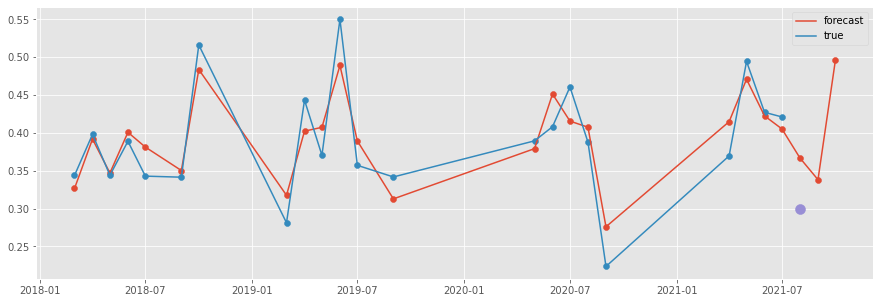

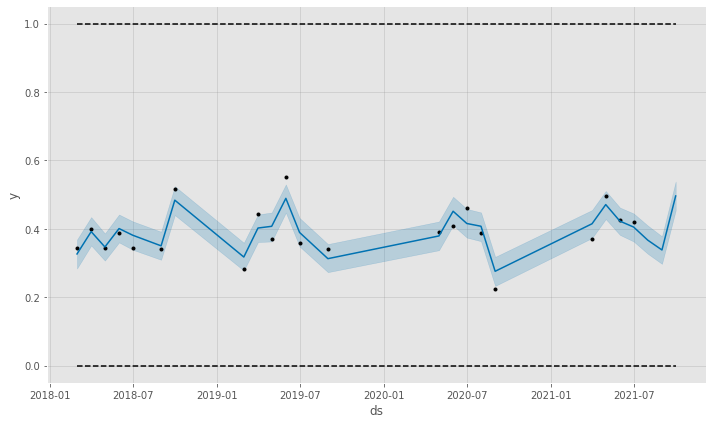

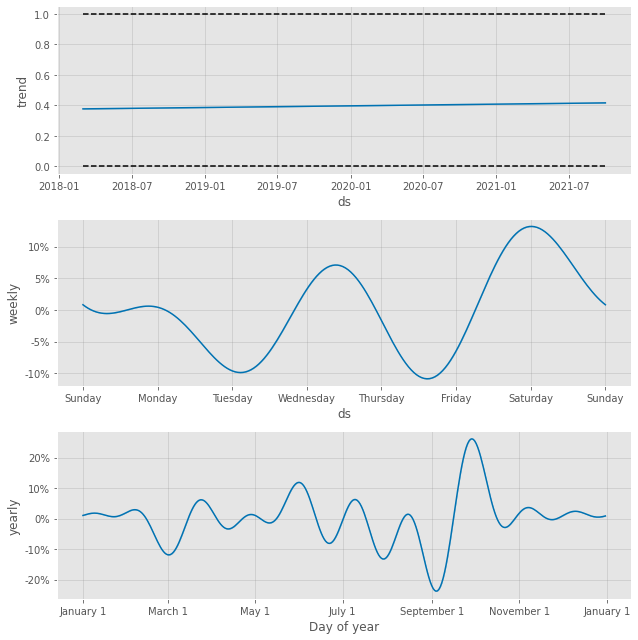

In [14]:
data = df_75847; target = 'OBP'
train = Preprocessing(data, target)
train = train.reset_index(drop = True)
np.random.seed(0)
train['cap'] = 1
train['floor'] = 0
model = Prophet(
                growth = 'logistic',
                seasonality_mode = 'multiplicative',
               changepoint_prior_scale = 0.1,
                seasonality_prior_scale = 0.04,
                yearly_seasonality = True,
                changepoint_range=0.8,
                weekly_seasonality= True,
                daily_seasonality = False
)
# 학습
model.fit(train)
# 예측 (3달 예측)
future = train[['ds']]
future.loc[26] = pd.to_datetime("2021-08-01")
future.loc[27] = pd.to_datetime("2021-09-01")
future.loc[28] = pd.to_datetime("2021-10-01")
future['cap'] = 1
future['floor'] = 0
forecast = model.predict(future)
plot_result(forecast, train, 0.3)
fig1 = model.plot(forecast)
fig1 = model.plot_components(forecast)

In [15]:
OBP_75847 = (2/3 * forecast['yhat'].iloc[-2]) + (1/3 * forecast['yhat'].iloc[-1])
print(' 9월 예측 : {}'.format(forecast['yhat'].iloc[-2]))
print(' 10월 예측 : {}'.format(forecast['yhat'].iloc[-1]))
print(' 총 예측 : {}'.format(OBP_75847))

 9월 예측 : 0.3381714384517708
 10월 예측 : 0.4960020062152482
 총 예측 : 0.39078162770626323


* SLG

INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


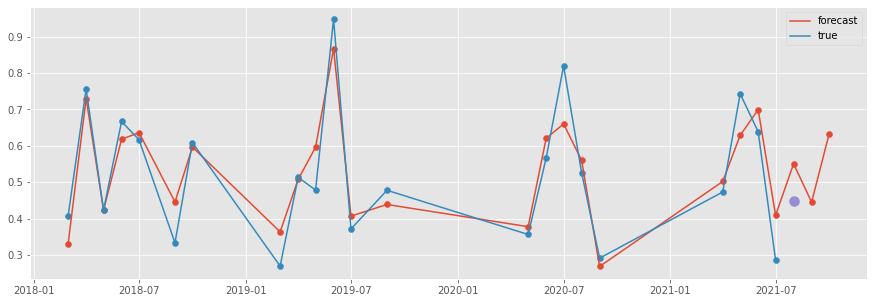

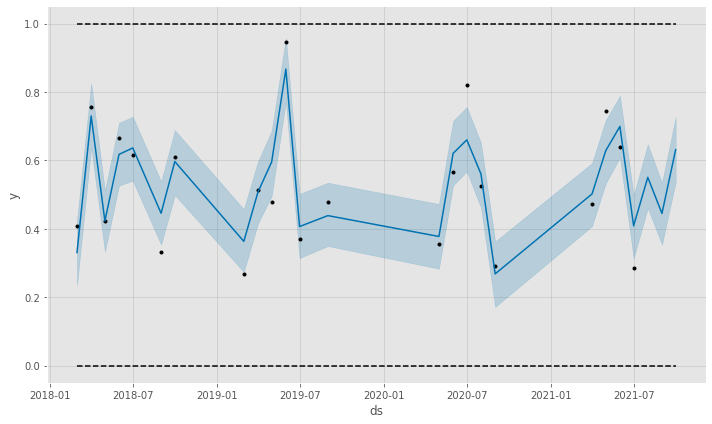

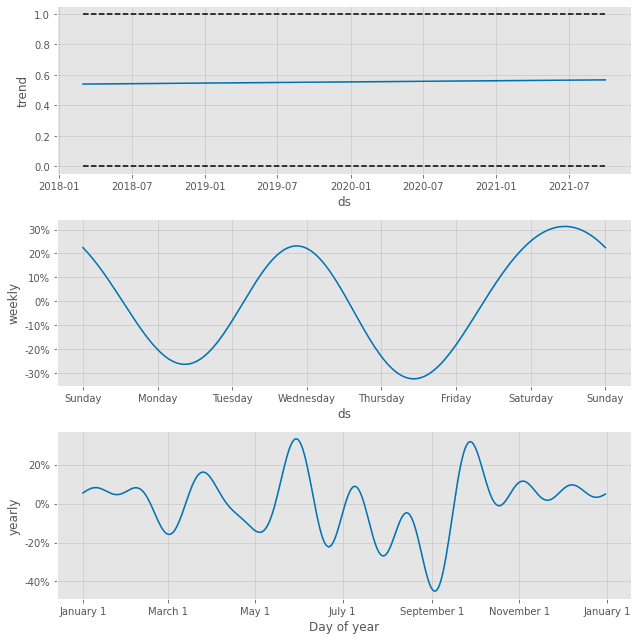

In [16]:
data = df_75847; target = 'SLG'
train = Preprocessing(data, target)
train = train.reset_index(drop = True)
np.random.seed(0)
train['cap'] = 1
train['floor'] = 0
model = Prophet(
                growth = 'logistic',
                seasonality_mode = 'multiplicative',
               changepoint_prior_scale = 1,
                seasonality_prior_scale = 0.1,
                yearly_seasonality = True,
                changepoint_range=0.8,
                weekly_seasonality= True,
                daily_seasonality = False
)
# 학습
model.fit(train)
# 예측 (3달 예측)
future = train[['ds']]
future.loc[26] = pd.to_datetime("2021-08-01")
future.loc[27] = pd.to_datetime("2021-09-01")
future.loc[28] = pd.to_datetime("2021-10-01")
future['cap'] = 1
future['floor'] = 0
forecast = model.predict(future)
plot_result(forecast, train, 0.448979591836735)
fig1 = model.plot(forecast)
fig1 = model.plot_components(forecast)

In [17]:
SLG_75847 = (2/3 * forecast['yhat'].iloc[-2]) + (1/3 * forecast['yhat'].iloc[-1])
print(' 9월 예측 : {}'.format(forecast['yhat'].iloc[-2]))
print(' 10월 예측 : {}'.format(forecast['yhat'].iloc[-1]))
print(' 총 예측 : {}'.format(SLG_75847))

 9월 예측 : 0.44496225780876203
 10월 예측 : 0.6313837787318031
 총 예측 : 0.507102764783109


### 3.4 이정후

* OBP

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


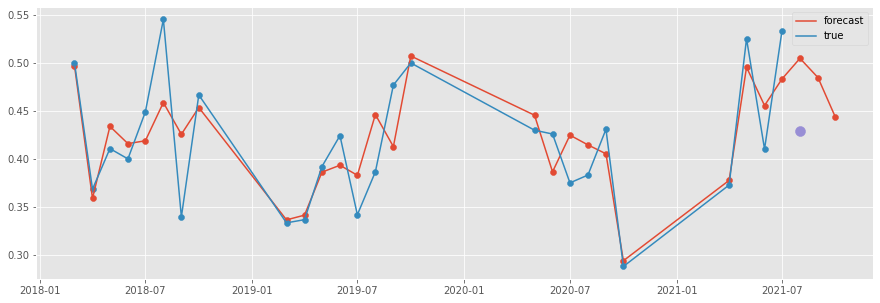

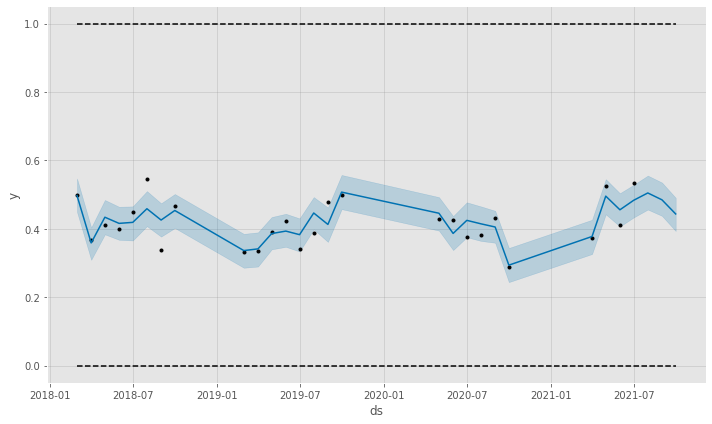

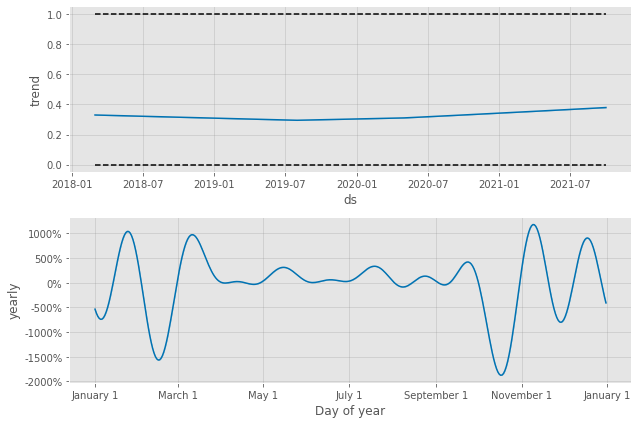

In [18]:
data = df_67341; target = 'OBP'
train = Preprocessing(data, target)
train = train.reset_index(drop = True)
np.random.seed(0)
train['cap'] = 1
train['floor'] = 0
model = Prophet(
                growth = 'logistic',
                seasonality_mode = 'multiplicative',
               changepoint_prior_scale = 0.5,
                seasonality_prior_scale = 10,
                yearly_seasonality = True,
                changepoint_range=0.8,
                weekly_seasonality= False,
                daily_seasonality = False
)
# 학습
model.fit(train)
# 예측 (3달 예측)
future = train[['ds']]
future.loc[26] = pd.to_datetime("2021-08-01")
future.loc[27] = pd.to_datetime("2021-09-01")
future.loc[28] = pd.to_datetime("2021-10-01")
future['cap'] = 1
future['floor'] = 0
forecast = model.predict(future)
plot_result(forecast, train, 0.428571428571429)
fig1 = model.plot(forecast)
fig1 = model.plot_components(forecast)

In [19]:
OBP_67341 = (2/3 * forecast['yhat'].iloc[-2]) + (1/3 * forecast['yhat'].iloc[-1])
print(' 9월 예측 : {}'.format(forecast['yhat'].iloc[-2]))
print(' 10월 예측 : {}'.format(forecast['yhat'].iloc[-1]))
print(' 총 예측 : {}'.format(OBP_67341))

 9월 예측 : 0.4847532489329454
 10월 예측 : 0.44344288057584125
 총 예측 : 0.470983126147244


* SLG

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


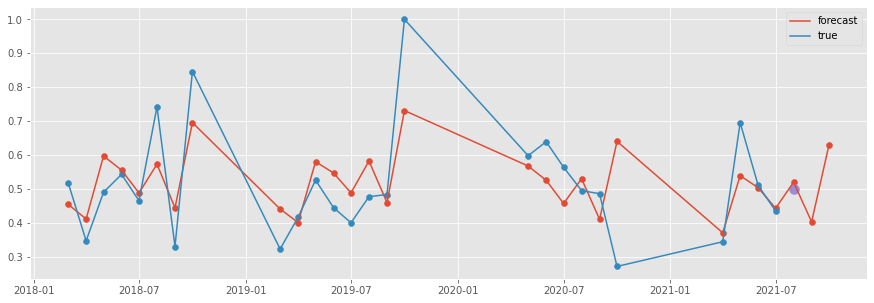

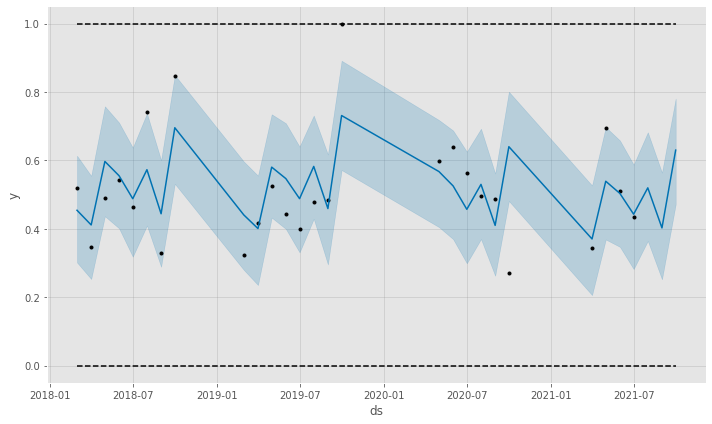

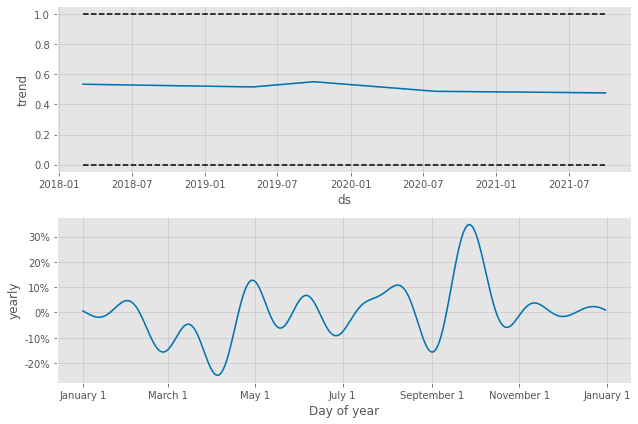

In [20]:
data = df_67341; target = 'SLG'
train = Preprocessing(data, target)
train = train.reset_index(drop = True)
np.random.seed(0)
train['cap'] = 1
train['floor'] = 0
model = Prophet(
                growth = 'logistic',
                seasonality_mode = 'multiplicative',
               changepoint_prior_scale = 5,
                seasonality_prior_scale = 0.1,
                yearly_seasonality = True,
                changepoint_range=0.8,
                weekly_seasonality= False,
                daily_seasonality = False
)
# 학습
model.fit(train)
# 예측 (3달 예측)
future = train[['ds']]
future.loc[26] = pd.to_datetime("2021-08-01")
future.loc[27] = pd.to_datetime("2021-09-01")
future.loc[28] = pd.to_datetime("2021-10-01")
future['cap'] = 1
future['floor'] = 0
forecast = model.predict(future)
plot_result(forecast, train, 0.5)
fig1 = model.plot(forecast)
fig1 = model.plot_components(forecast)

In [21]:
SLG_67341 = (2/3 * forecast['yhat'].iloc[-2]) + (1/3 * forecast['yhat'].iloc[-1])
print(' 9월 예측 : {}'.format(forecast['yhat'].iloc[-2]))
print(' 10월 예측 : {}'.format(forecast['yhat'].iloc[-1]))
print(' 총 예측 : {}'.format(SLG_67341))

 9월 예측 : 0.4026727435890564
 10월 예측 : 0.6299830622221234
 총 예측 : 0.4784428498000787


### 3.5 채은성

* OBP

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


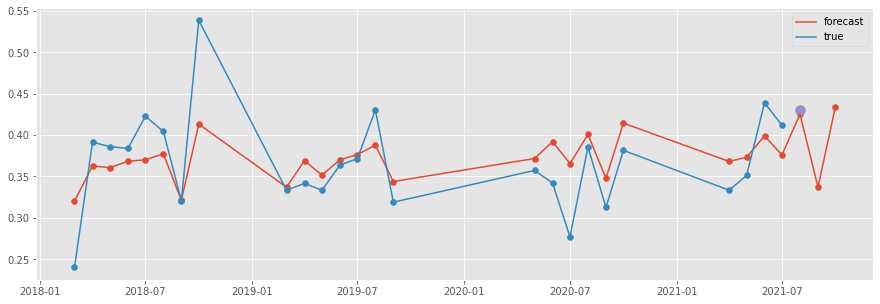

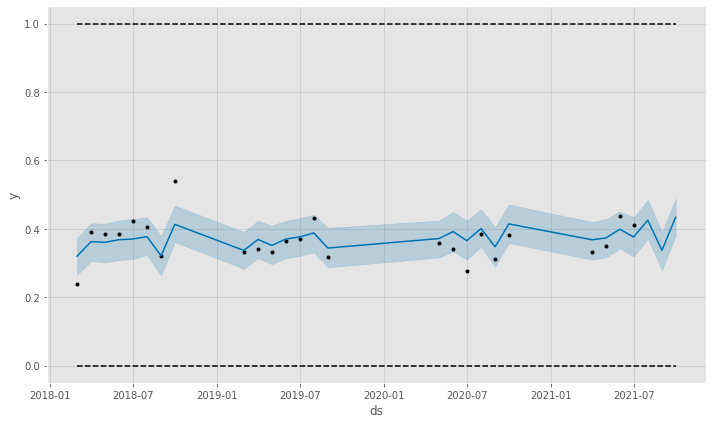

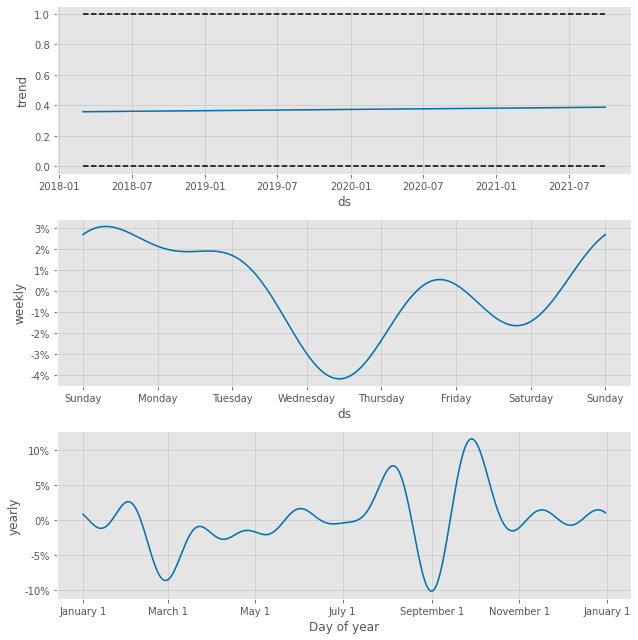

In [22]:
data = df_79192; target = 'OBP'
train = Preprocessing(data, target)
train = train.reset_index(drop = True)
np.random.seed(0)
train['cap'] = 1
train['floor'] = 0
model = Prophet(
                growth = 'logistic',
                seasonality_mode = 'multiplicative',
               changepoint_prior_scale = 0.01,
                seasonality_prior_scale = 0.025,
                yearly_seasonality = True,
                changepoint_range=0.8,
                weekly_seasonality= True,
                daily_seasonality = False
)
# 학습
model.fit(train)
# 예측 (3달 예측)
future = train[['ds']]
future.loc[26] = pd.to_datetime("2021-08-01")
future.loc[27] = pd.to_datetime("2021-09-01")
future.loc[28] = pd.to_datetime("2021-10-01")
future['cap'] = 1
future['floor'] = 0
forecast = model.predict(future)
plot_result(forecast, train, 0.43)
fig1 = model.plot(forecast)
fig1 = model.plot_components(forecast)

In [23]:
OBP_79192 = (2/3 * forecast['yhat'].iloc[-2]) + (1/3 * forecast['yhat'].iloc[-1])
print(' 9월 예측 : {}'.format(forecast['yhat'].iloc[-2]))
print(' 10월 예측 : {}'.format(forecast['yhat'].iloc[-1]))
print(' 총 예측 : {}'.format(OBP_79192))

 9월 예측 : 0.3370630674112327
 10월 예측 : 0.43389087810497295
 총 예측 : 0.3693390043091461


* SLG

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


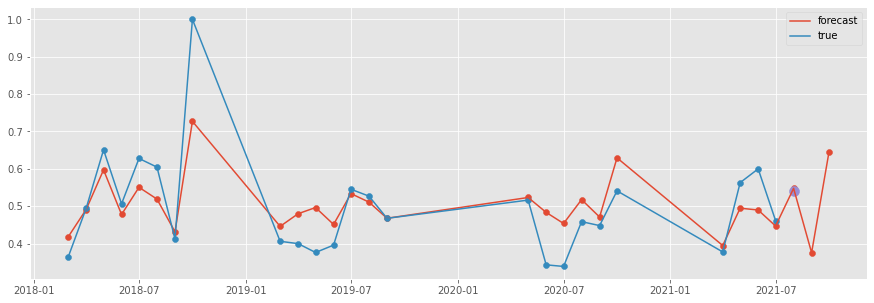

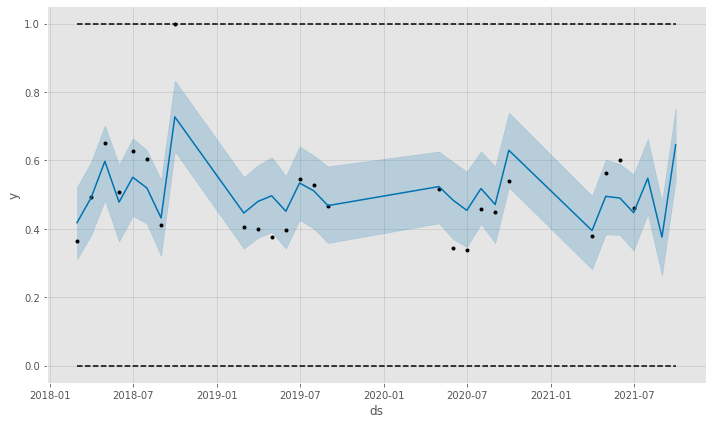

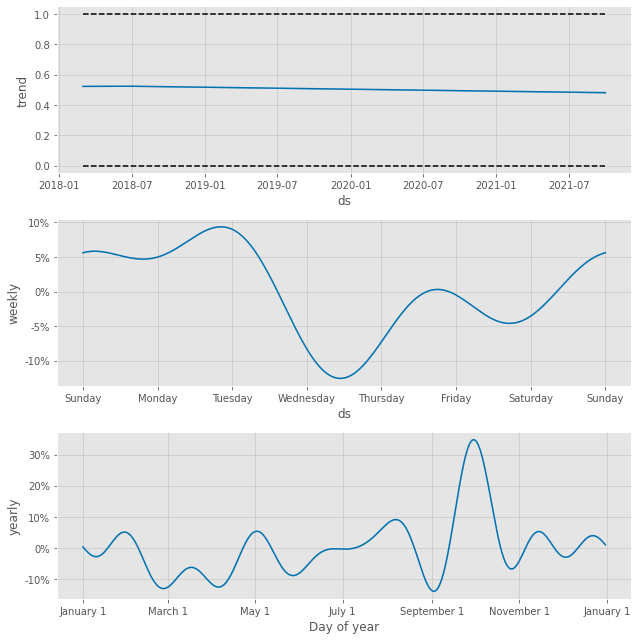

In [24]:
data = df_79192; target = 'SLG'
train = Preprocessing(data, target)
train = train.reset_index(drop = True)
np.random.seed(0)
train['cap'] = 1
train['floor'] = 0
model = Prophet(
                growth = 'logistic',
                seasonality_mode = 'multiplicative',
               changepoint_prior_scale = 0.2,
                seasonality_prior_scale = 0.05,
                yearly_seasonality = True,
                changepoint_range=0.8,
                weekly_seasonality= True,
                daily_seasonality = False
)
# 학습
model.fit(train)
# 예측 (3달 예측)
future = train[['ds']]
future.loc[26] = pd.to_datetime("2021-08-01")
future.loc[27] = pd.to_datetime("2021-09-01")
future.loc[28] = pd.to_datetime("2021-10-01")
future['cap'] = 1
future['floor'] = 0
forecast = model.predict(future)
plot_result(forecast, train, 0.54)
fig1 = model.plot(forecast)
fig1 = model.plot_components(forecast)

In [25]:
SLG_79192 = (2/3 * forecast['yhat'].iloc[-2]) + (1/3 * forecast['yhat'].iloc[-1])
print(' 9월 예측 : {}'.format(forecast['yhat'].iloc[-2]))
print(' 10월 예측 : {}'.format(forecast['yhat'].iloc[-1]))
print(' 총 예측 : {}'.format(SLG_79192))

 9월 예측 : 0.3757280187797599
 10월 예측 : 0.64564655865864
 총 예측 : 0.46570086540605327


### 3.6 김재환

* OBP

INFO:fbprophet:n_changepoints greater than number of observations. Using 18.


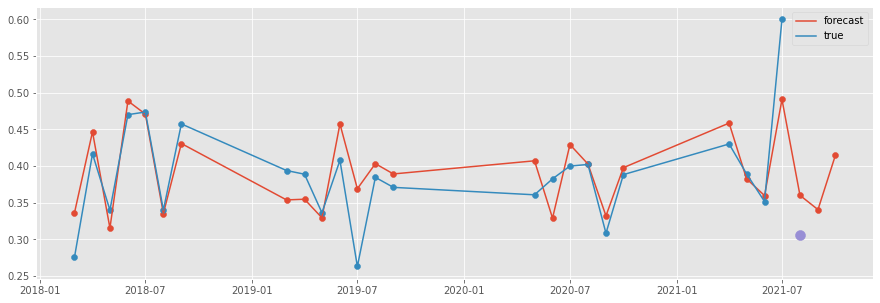

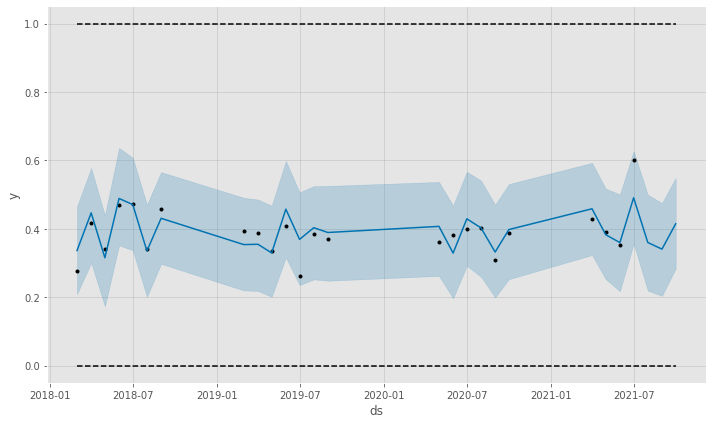

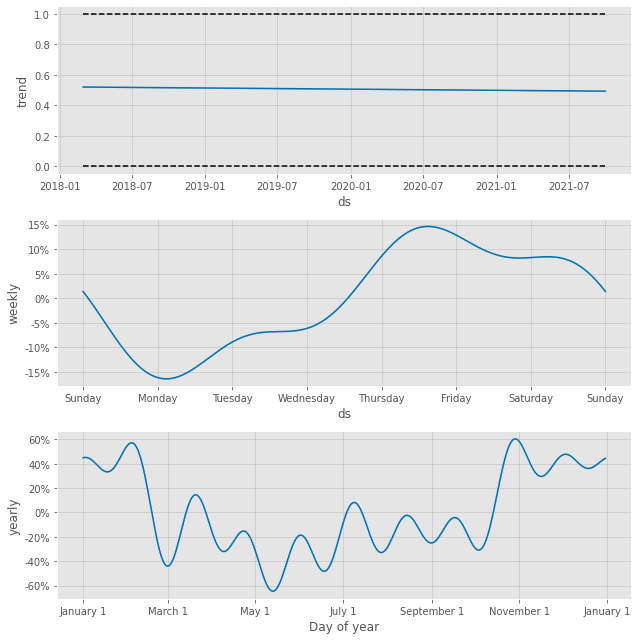

In [26]:
data = df_78224; target = 'OBP'
train = Preprocessing(data, target)
train = train.reset_index(drop = True)
np.random.seed(0)
train['cap'] = 1
train['floor'] = 0
model = Prophet(
                growth = 'logistic',
                seasonality_mode = 'multiplicative',
               changepoint_prior_scale = 0.00001,
                seasonality_prior_scale = 0.5,
                yearly_seasonality = True,
                changepoint_range=0.8,
                weekly_seasonality= True,
                daily_seasonality = False
)
# 학습
model.fit(train)
# 예측 (3달 예측)
future = train[['ds']]
future.loc[26] = pd.to_datetime("2021-08-01")
future.loc[27] = pd.to_datetime("2021-09-01")
future.loc[28] = pd.to_datetime("2021-10-01")
future['cap'] = 1
future['floor'] = 0
forecast = model.predict(future)
plot_result(forecast, train, 0.306451612903226)
fig1 = model.plot(forecast)
fig1 = model.plot_components(forecast)

In [27]:
OBP_78224 = (2/3 * forecast['yhat'].iloc[-2]) + (1/3 * forecast['yhat'].iloc[-1])
print(' 9월 예측 : {}'.format(forecast['yhat'].iloc[-2]))
print(' 10월 예측 : {}'.format(forecast['yhat'].iloc[-1]))
print(' 총 예측 : {}'.format(OBP_78224))

 9월 예측 : 0.3406269553448055
 10월 예측 : 0.4146973694569787
 총 예측 : 0.3653170933821966


* SLG

INFO:fbprophet:n_changepoints greater than number of observations. Using 18.


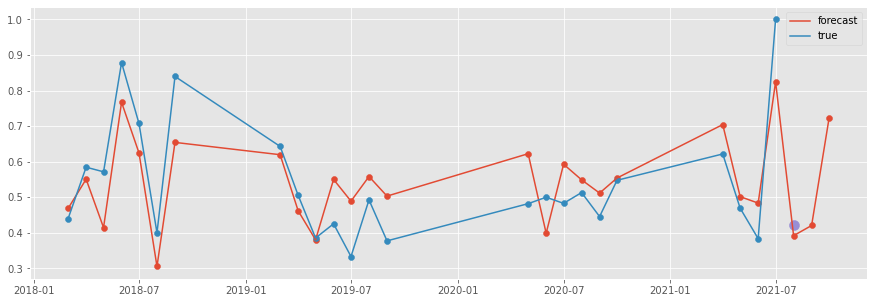

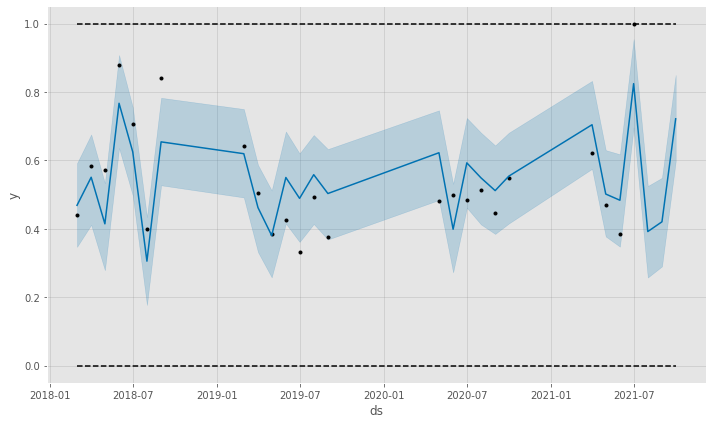

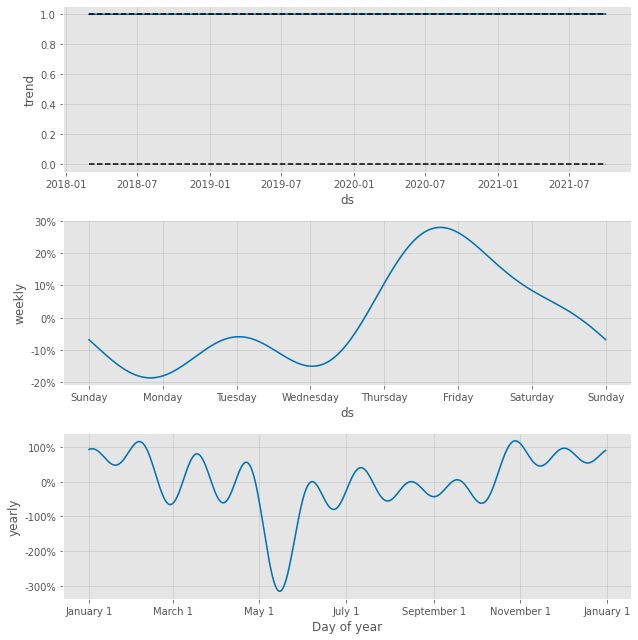

In [28]:
data = df_78224; target = 'SLG'
train = Preprocessing(data, target)
train = train.reset_index(drop = True)
np.random.seed(0)
train['cap'] = 1
train['floor'] = 0
model = Prophet(
                growth = 'logistic',
                seasonality_mode = 'multiplicative',
               changepoint_prior_scale = 1,
                seasonality_prior_scale = 0.5,
                yearly_seasonality = True,
                changepoint_range=0.8,
                weekly_seasonality= True,
                daily_seasonality = False
)
# 학습
model.fit(train)
# 예측 (3달 예측)
future = train[['ds']]
future.loc[26] = pd.to_datetime("2021-08-01")
future.loc[27] = pd.to_datetime("2021-09-01")
future.loc[28] = pd.to_datetime("2021-10-01")
future['cap'] = 1
future['floor'] = 0
forecast = model.predict(future)
plot_result(forecast, train, 0.421052631578947)
fig1 = model.plot(forecast)
fig1 = model.plot_components(forecast)

In [29]:
SLG_78224 = (2/3 * forecast['yhat'].iloc[-2]) + (1/3 * forecast['yhat'].iloc[-1])
print(' 9월 예측 : {}'.format(forecast['yhat'].iloc[-2]))
print(' 10월 예측 : {}'.format(forecast['yhat'].iloc[-1]))
print(' 총 예측 : {}'.format(SLG_78224))

 9월 예측 : 0.4205362757610996
 10월 예측 : 0.7214841641480546
 총 예측 : 0.5208522385567512


### 3.7 전준우

* OBP

INFO:fbprophet:n_changepoints greater than number of observations. Using 18.


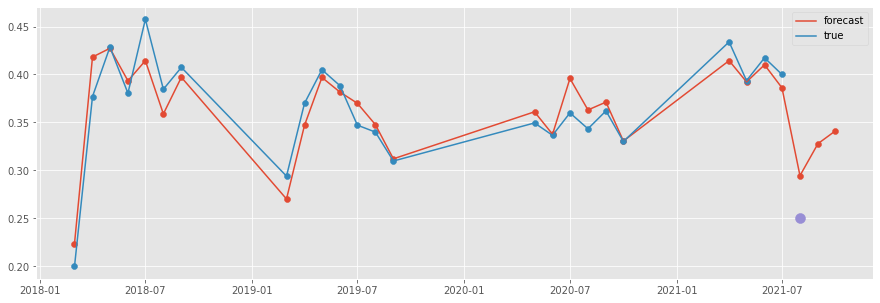

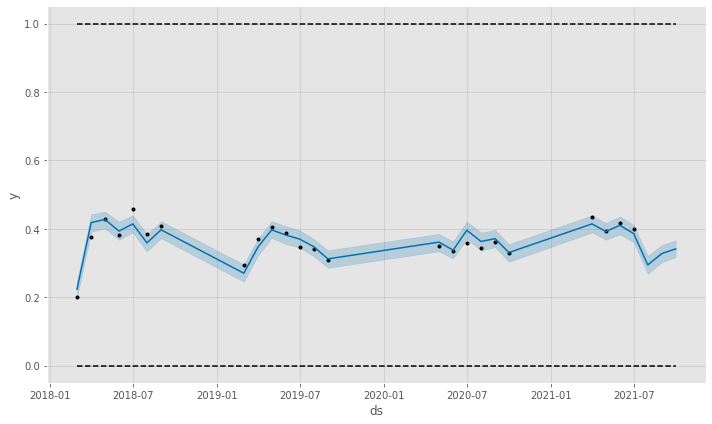

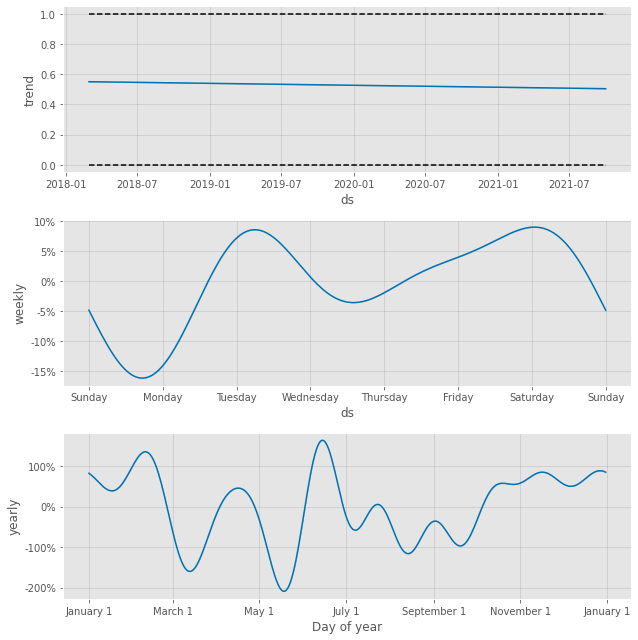

In [30]:
data = df_78513; target = 'OBP'
train = Preprocessing(data, target)
train = train.reset_index(drop = True)
np.random.seed(0)
train['cap'] = 1
train['floor'] = 0
model = Prophet(
                growth = 'logistic',
                seasonality_mode = 'multiplicative',
               changepoint_prior_scale = 0.1,
                seasonality_prior_scale = 0.5,
                yearly_seasonality = True,
                changepoint_range=0.8,
                weekly_seasonality= True,
                daily_seasonality = False
)
# 학습
model.fit(train)
# 예측 (3달 예측)
future = train[['ds']]
future.loc[26] = pd.to_datetime("2021-08-01")
future.loc[27] = pd.to_datetime("2021-09-01")
future.loc[28] = pd.to_datetime("2021-10-01")
future['cap'] = 1
future['floor'] = 0
forecast = model.predict(future)
plot_result(forecast, train, 0.25)
fig1 = model.plot(forecast)
fig1 = model.plot_components(forecast)

In [31]:
OBP_78513 = (2/3 * forecast['yhat'].iloc[-2]) + (1/3 * forecast['yhat'].iloc[-1])
print(' 9월 예측 : {}'.format(forecast['yhat'].iloc[-2]))
print(' 10월 예측 : {}'.format(forecast['yhat'].iloc[-1]))
print(' 총 예측 : {}'.format(OBP_78513))

 9월 예측 : 0.3279424383717292
 10월 예측 : 0.34127037374528457
 총 예측 : 0.3323850834962476


* SLG

INFO:fbprophet:n_changepoints greater than number of observations. Using 18.


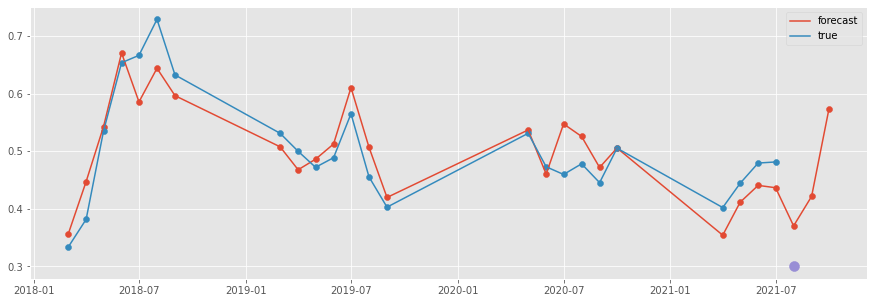

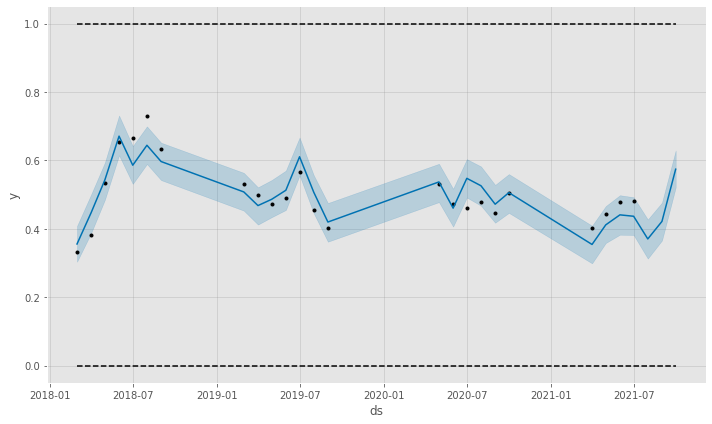

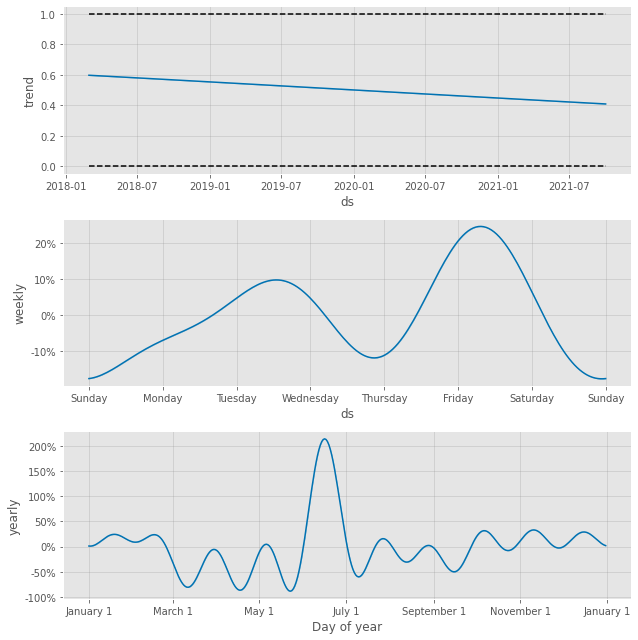

In [32]:
data = df_78513; target = 'SLG'
train = Preprocessing(data, target)
train = train.reset_index(drop = True)
np.random.seed(0)
train['cap'] = 1
train['floor'] = 0
model = Prophet(
                growth = 'logistic',
                seasonality_mode = 'multiplicative',
               changepoint_prior_scale = 0.1,
                seasonality_prior_scale = 0.5,
                yearly_seasonality = True,
                changepoint_range=0.8,
                weekly_seasonality= True,
                daily_seasonality = False
)
# 학습
model.fit(train)
# 예측 (3달 예측)
future = train[['ds']]
future.loc[26] = pd.to_datetime("2021-08-01")
future.loc[27] = pd.to_datetime("2021-09-01")
future.loc[28] = pd.to_datetime("2021-10-01")
future['cap'] = 1
future['floor'] = 0
forecast = model.predict(future)
plot_result(forecast, train, 0.3)
fig1 = model.plot(forecast)
fig1 = model.plot_components(forecast)

In [33]:
SLG_78513 = (2/3 * forecast['yhat'].iloc[-2]) + (1/3 * forecast['yhat'].iloc[-1])
print(' 9월 예측 : {}'.format(forecast['yhat'].iloc[-2]))
print(' 10월 예측 : {}'.format(forecast['yhat'].iloc[-1]))
print(' 총 예측 : {}'.format(SLG_78513))

 9월 예측 : 0.4216749167567061
 10월 예측 : 0.5742216846185075
 총 예측 : 0.4725238393773066


### 3.8 김현수

* OBP

INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


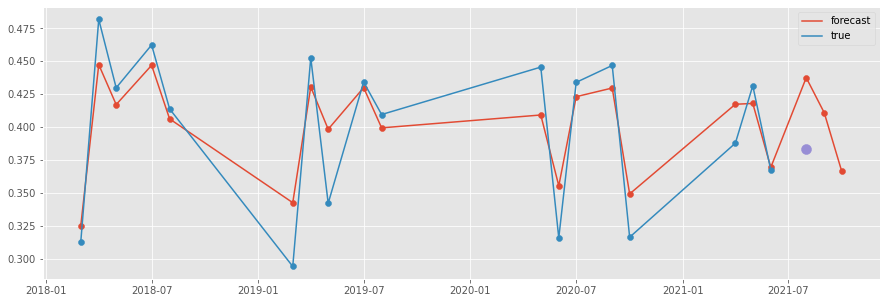

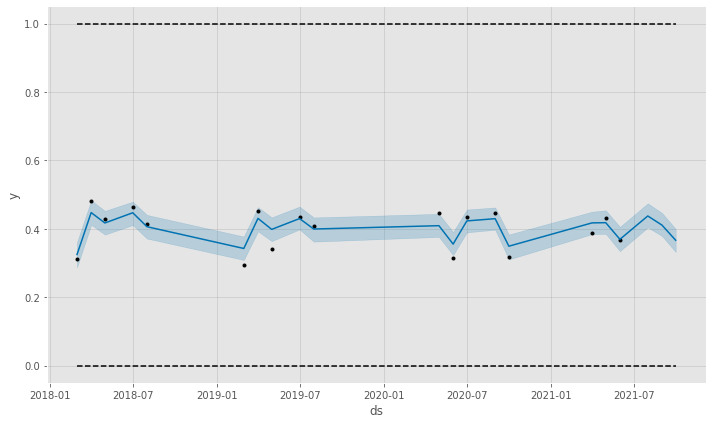

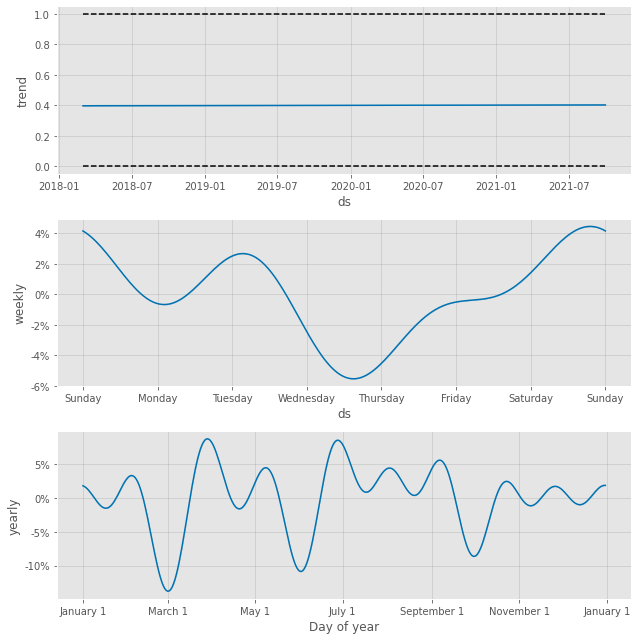

In [34]:
data = df_76290; target = 'OBP'
train = Preprocessing(data, target)
train = train.reset_index(drop = True)
np.random.seed(0)
train['cap'] = 1
train['floor'] = 0
model = Prophet(
                growth = 'logistic',
                seasonality_mode = 'multiplicative',
               changepoint_prior_scale = 0.1,
                seasonality_prior_scale = 0.02,
                yearly_seasonality = True,
                changepoint_range=0.8,
                weekly_seasonality= True,
                daily_seasonality = False
)
# 학습
model.fit(train)
# 예측 (3달 예측)
future = train[['ds']]
future.loc[26] = pd.to_datetime("2021-08-01")
future.loc[27] = pd.to_datetime("2021-09-01")
future.loc[28] = pd.to_datetime("2021-10-01")
future['cap'] = 1
future['floor'] = 0
forecast = model.predict(future)
plot_result(forecast, train, 0.383333333333333)
fig1 = model.plot(forecast)
fig1 = model.plot_components(forecast)

In [35]:
OBP_76290 = (2/3 * forecast['yhat'].iloc[-2]) + (1/3 * forecast['yhat'].iloc[-1])
print(' 9월 예측 : {}'.format(forecast['yhat'].iloc[-2]))
print(' 10월 예측 : {}'.format(forecast['yhat'].iloc[-1]))
print(' 총 예측 : {}'.format(OBP_76290))

 9월 예측 : 0.41087431895353765
 10월 예측 : 0.36660456855653073
 총 예측 : 0.39611773548786866


* SLG

INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


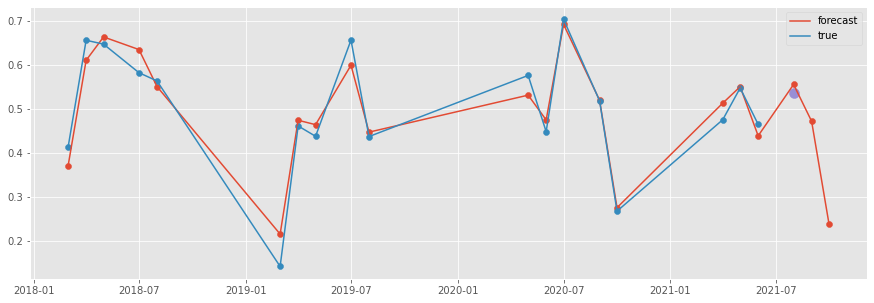

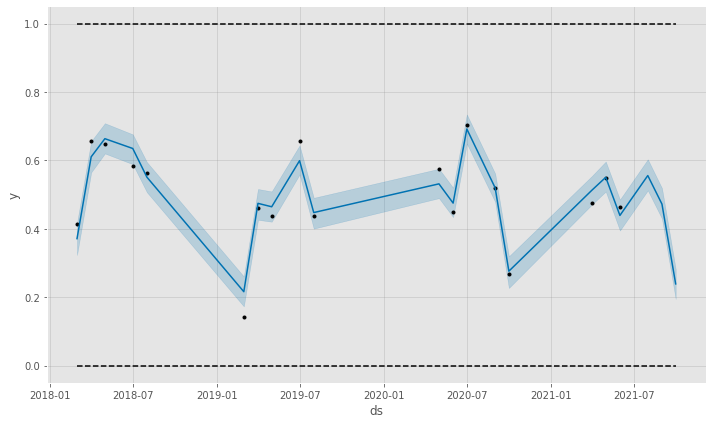

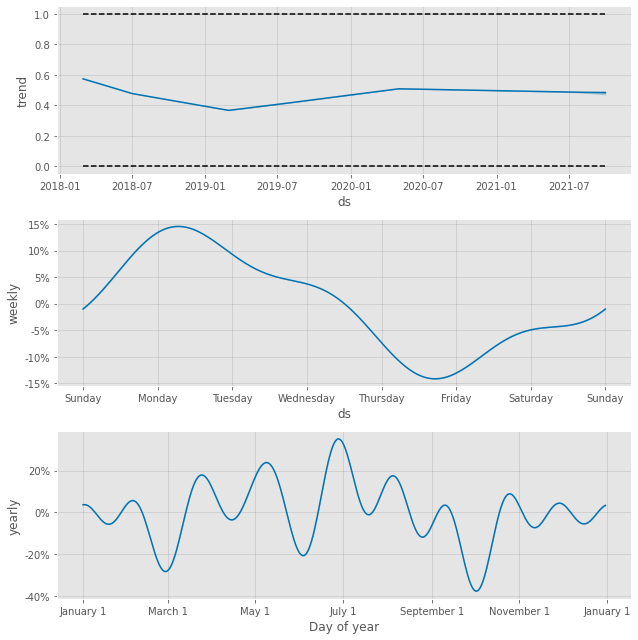

In [36]:
data = df_76290; target = 'SLG'
train = Preprocessing(data, target)
train = train.reset_index(drop = True)
np.random.seed(0)
train['cap'] = 1
train['floor'] = 0
model = Prophet(
                growth = 'logistic',
                seasonality_mode = 'multiplicative',
               changepoint_prior_scale = 1,
                seasonality_prior_scale = 0.1,
                yearly_seasonality = True,
                changepoint_range=0.8,
                weekly_seasonality= True,
                daily_seasonality = False
)
# 학습
model.fit(train)
# 예측 (3달 예측)
future = train[['ds']]
future.loc[26] = pd.to_datetime("2021-08-01")
future.loc[27] = pd.to_datetime("2021-09-01")
future.loc[28] = pd.to_datetime("2021-10-01")
future['cap'] = 1
future['floor'] = 0
forecast = model.predict(future)
plot_result(forecast, train, 0.537037037037037)
fig1 = model.plot(forecast)
fig1 = model.plot_components(forecast)

In [37]:
SLG_76290 = (2/3 * forecast['yhat'].iloc[-2]) + (1/3 * forecast['yhat'].iloc[-1])
print(' 9월 예측 : {}'.format(forecast['yhat'].iloc[-2]))
print(' 10월 예측 : {}'.format(forecast['yhat'].iloc[-1]))
print(' 총 예측 : {}'.format(SLG_76290))

 9월 예측 : 0.47226163289384354
 10월 예측 : 0.23903963553206764
 총 예측 : 0.39452096710658485


### 3.9 박건우

* OBP

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


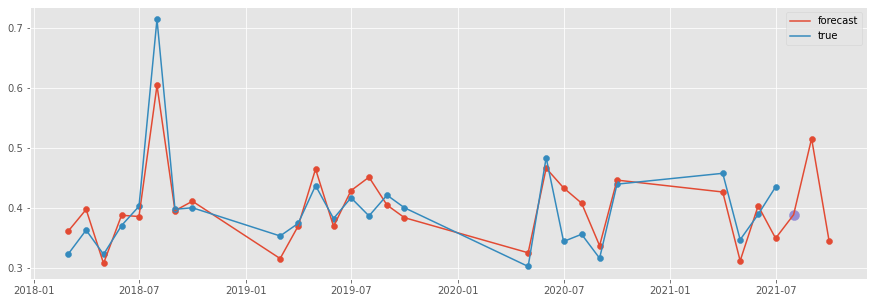

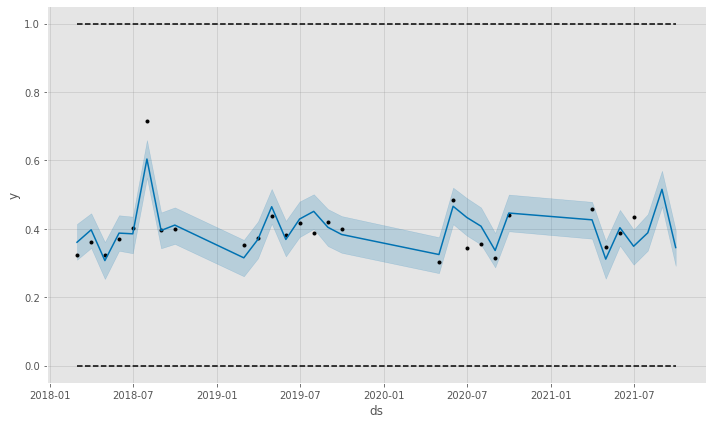

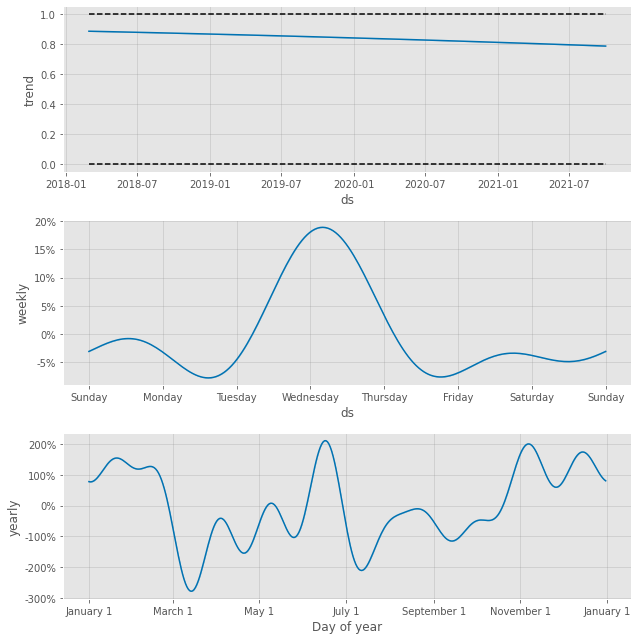

In [38]:
data = df_79215; target = 'OBP'
train = Preprocessing(data, target)
train = train.reset_index(drop = True)
np.random.seed(0)
train['cap'] = 1
train['floor'] = 0
model = Prophet(
                growth = 'logistic',
                seasonality_mode = 'multiplicative',
               changepoint_prior_scale = 0.1,
                seasonality_prior_scale = 0.6,
                yearly_seasonality = True,
                changepoint_range=0.8,
                weekly_seasonality= True,
                daily_seasonality = False
)
# 학습
model.fit(train)
# 예측 (3달 예측)
future = train[['ds']]
future.loc[26] = pd.to_datetime("2021-08-01")
future.loc[27] = pd.to_datetime("2021-09-01")
future.loc[28] = pd.to_datetime("2021-10-01")
future['cap'] = 1
future['floor'] = 0
forecast = model.predict(future)
plot_result(forecast, train, 0.388059701492537)
fig1 = model.plot(forecast)
fig1 = model.plot_components(forecast)

In [39]:
OBP_79215 = (2/3 * forecast['yhat'].iloc[-2]) + (1/3 * forecast['yhat'].iloc[-1])
print(' 9월 예측 : {}'.format(forecast['yhat'].iloc[-2]))
print(' 10월 예측 : {}'.format(forecast['yhat'].iloc[-1]))
print(' 총 예측 : {}'.format(OBP_79215))

 9월 예측 : 0.5154239476634909
 10월 예측 : 0.3452997351295874
 총 예측 : 0.45871587681885634


* SLG

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


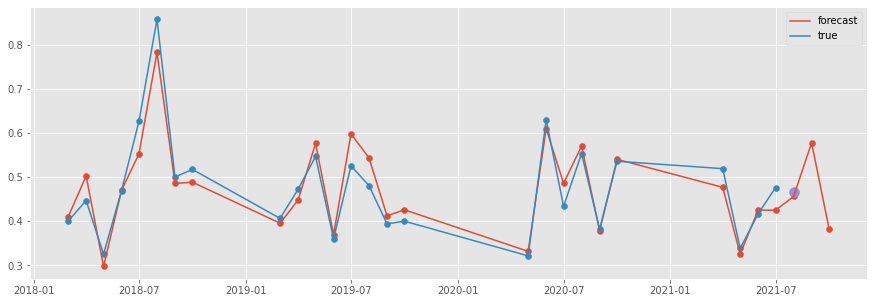

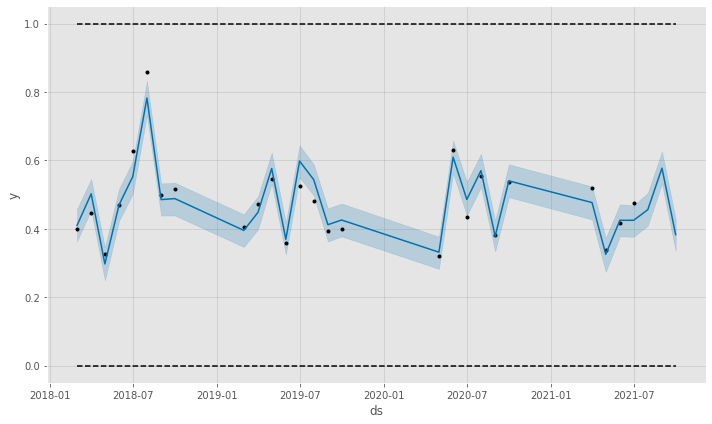

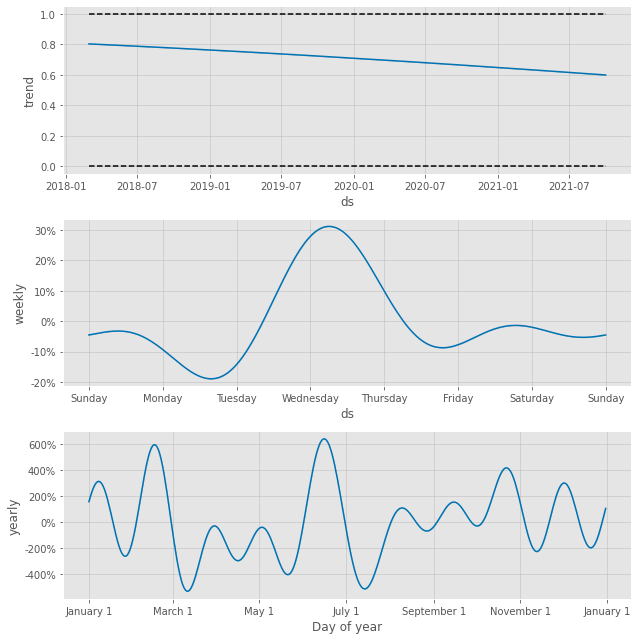

In [40]:
data = df_79215; target = 'SLG'
train = Preprocessing(data, target)
train = train.reset_index(drop = True)
np.random.seed(0)
train['cap'] = 1
train['floor'] = 0
model = Prophet(
                growth = 'logistic',
                seasonality_mode = 'multiplicative',
               changepoint_prior_scale = 0.005,
                seasonality_prior_scale = 1.8,
                yearly_seasonality = True,
                changepoint_range=0.8,
                weekly_seasonality= True,
                daily_seasonality = False
)
# 학습
model.fit(train)
# 예측 (3달 예측)
future = train[['ds']]
future.loc[26] = pd.to_datetime("2021-08-01")
future.loc[27] = pd.to_datetime("2021-09-01")
future.loc[28] = pd.to_datetime("2021-10-01")
future['cap'] = 1
future['floor'] = 0
forecast = model.predict(future)
plot_result(forecast, train, 0.46551724137931)
fig1 = model.plot(forecast)
fig1 = model.plot_components(forecast)

In [41]:
SLG_79215 = (2/3 * forecast['yhat'].iloc[-2]) + (1/3 * forecast['yhat'].iloc[-1])
print(' 9월 예측 : {}'.format(forecast['yhat'].iloc[-2]))
print(' 10월 예측 : {}'.format(forecast['yhat'].iloc[-1]))
print(' 총 예측 : {}'.format(SLG_79215))

 9월 예측 : 0.5772351949343718
 10월 예측 : 0.38309947060752486
 총 예측 : 0.5125232868254228


### 3.10 로맥

* OBP

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


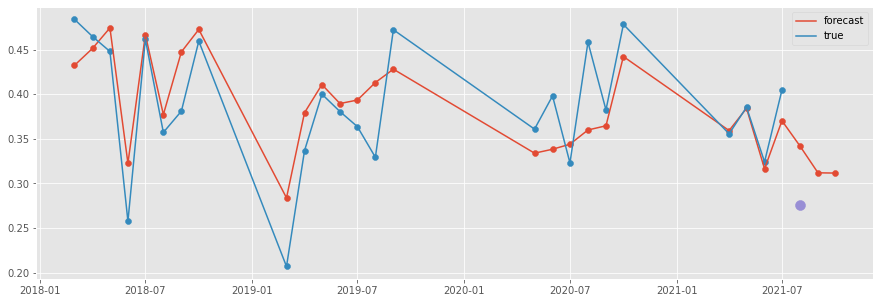

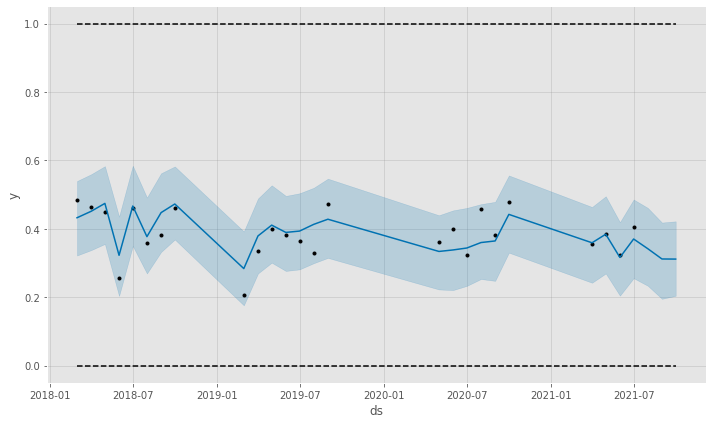

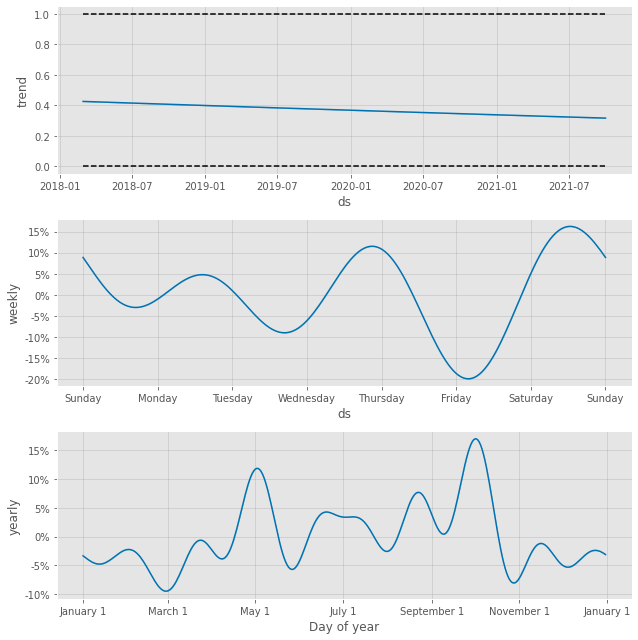

In [42]:
data = df_67872; target = 'OBP'
train = Preprocessing(data, target)
train = train.reset_index(drop = True)
np.random.seed(0)
train['cap'] = 1
train['floor'] = 0
model = Prophet(
                growth = 'logistic',
                seasonality_mode = 'multiplicative',
               changepoint_prior_scale = 0.00002,
                seasonality_prior_scale = 0.1,
                yearly_seasonality = True,
                changepoint_range=0.8,
                weekly_seasonality= True,
                daily_seasonality = False
)
# 학습
model.fit(train)
# 예측 (3달 예측)
future = train[['ds']]
future.loc[26] = pd.to_datetime("2021-08-01")
future.loc[27] = pd.to_datetime("2021-09-01")
future.loc[28] = pd.to_datetime("2021-10-01")
future['cap'] = 1
future['floor'] = 0
forecast = model.predict(future)
plot_result(forecast, train, 0.275862068965517)
fig1 = model.plot(forecast)
fig1 = model.plot_components(forecast)

In [43]:
OBP_67872 = (2/3 * forecast['yhat'].iloc[-2]) + (1/3 * forecast['yhat'].iloc[-1])
print(' 9월 예측 : {}'.format(forecast['yhat'].iloc[-2]))
print(' 10월 예측 : {}'.format(forecast['yhat'].iloc[-1]))
print(' 총 예측 : {}'.format(OBP_67872))

 9월 예측 : 0.31185925378870166
 10월 예측 : 0.3115536332571723
 총 예측 : 0.3117573802781919


* SLG

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


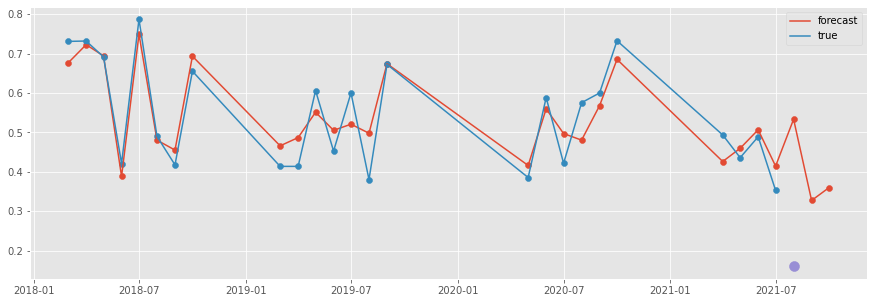

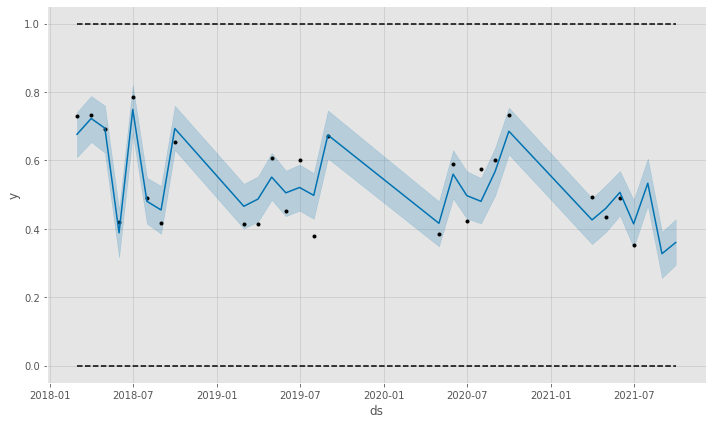

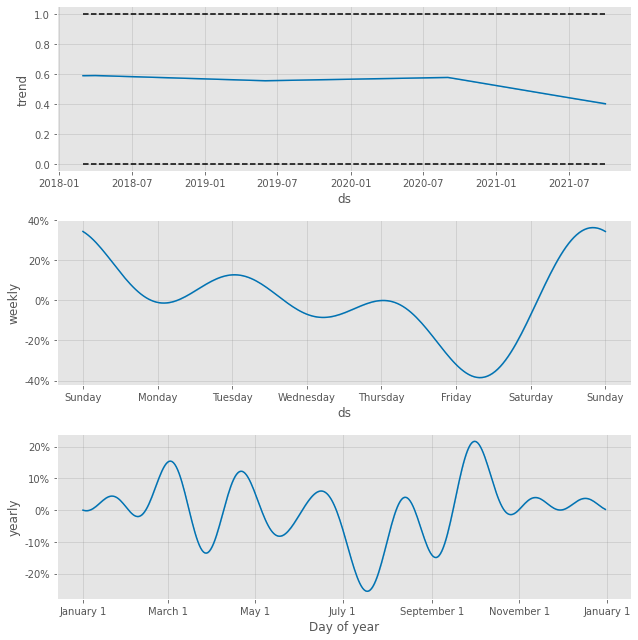

In [44]:
data = df_67872; target = 'SLG'
train = Preprocessing(data, target)
train = train.reset_index(drop = True)
np.random.seed(0)
train['cap'] = 1
train['floor'] = 0
model = Prophet(
                growth = 'logistic',
                seasonality_mode = 'multiplicative',
               changepoint_prior_scale = 1,
                seasonality_prior_scale = 0.1,
                yearly_seasonality = True,
                changepoint_range=0.8,
                weekly_seasonality= True,
                daily_seasonality = False
)
# 학습
model.fit(train)
# 예측 (3달 예측)
future = train[['ds']]
future.loc[26] = pd.to_datetime("2021-08-01")
future.loc[27] = pd.to_datetime("2021-09-01")
future.loc[28] = pd.to_datetime("2021-10-01")
future['cap'] = 1
future['floor'] = 0
forecast = model.predict(future)
plot_result(forecast, train, 0.16)
fig1 = model.plot(forecast)
fig1 = model.plot_components(forecast)

In [45]:
SLG_67872 = (2/3 * forecast['yhat'].iloc[-2]) + (1/3 * forecast['yhat'].iloc[-1])
print(' 9월 예측 : {}'.format(forecast['yhat'].iloc[-2]))
print(' 10월 예측 : {}'.format(forecast['yhat'].iloc[-1]))
print(' 총 예측 : {}'.format(SLG_67872))

 9월 예측 : 0.3273265245925721
 10월 예측 : 0.35993120904448334
 총 예측 : 0.3381947527432092


## 4. 예측 파일 저장 및 내보내기

    - 각 선수의 예측한 SLG, OBP를 합해 선수별 OPS를 계산함.
    
    - 그리고 선수코드, OPS, SLG, OBP를 제출 파일에 업로드한 후 제출 파일 생성

In [46]:
OPS_76232 = SLG_76232 + OBP_76232
OPS_68050 = SLG_68050 + OBP_68050
OPS_75847 = SLG_75847 + OBP_75847
OPS_67341 = SLG_67341 + OBP_67341
OPS_79192 = SLG_79192 + OBP_79192
OPS_78224 = SLG_78224 + OBP_78224
OPS_78513 = SLG_78513 + OBP_78513
OPS_76290 = SLG_76290 + OBP_76290
OPS_79215 = SLG_79215 + OBP_79215
OPS_67872 = SLG_67872 + OBP_67872


submission.loc[1] = [76232, OPS_76232, SLG_76232, OBP_76232]

submission.loc[2] = [68050, OPS_68050, SLG_68050, OBP_68050]

submission.loc[3] = [75847, OPS_75847, SLG_75847, OBP_75847]

submission.loc[4] = [67341, OPS_67341, SLG_67341, OBP_67341] 

submission.loc[5] = [79192, OPS_79192, SLG_79192, OBP_79192]

submission.loc[6] = [78224, OPS_78224, SLG_78224, OBP_78224] 

submission.loc[7] = [78513, OPS_78513, SLG_78513, OBP_78513]

submission.loc[8] = [76290, OPS_76290, SLG_76290, OBP_76290]

submission.loc[9] = [79215, OPS_79215, SLG_79215, OBP_79215]

submission.loc[10] = [67872, OPS_67872, SLG_67872, OBP_67872]

In [47]:
submission

,PCODE,OPS,장타율,출루율
NO.,,,,
NaN,(예시),1.090000,0.680000,0.417000
1,76232,1.007338,0.582064,0.425274
2,68050,1.013806,0.595516,0.418290
3,75847,0.897884,0.507103,0.390782
4,67341,0.949426,0.478443,0.470983
5,79192,0.835040,0.465701,0.369339
6,78224,0.886169,0.520852,0.365317
7,78513,0.804909,0.472524,0.332385
8,76290,0.790639,0.394521,0.396118


In [50]:
#최종결과 저장
path = '../평가데이터'
submission.to_excel(path+'/데이터분석분야_챔피언리그_스포츠테크_BASSG_평가데이터.xlsx')